In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
#Set Seed for repeatable Experiments
np.random.seed(123)

import itertools
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
import os


import struct
import gzip

import sys
import math



import PIL
from PIL import Image 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch.utils.data as data_utils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

gpuid = 0
if torch.cuda.is_available():
  print(torch.cuda.get_device_properties(gpuid))
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')
device

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Specify which dataset to use (MNIST/FashionMNIST) and which CNN to use (SimpleNet/DenseNet)

In [ ]:
#specify data to use
#use_data = 'MNIST'
use_data = 'FashionMNIST'

#model_type = 'SimpleNet'
model_type = 'DenseNet'

## Location of MNIST Data on google drive

In [ ]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/Data/{}'.format(use_data)
if use_data == 'MNIST':
  MNIST_dict = {0:'Zero', 1:'One', 2:'Two',
    3:'Three', 4:'Four', 5:'Five', 6:'Six',
    7:'Seven', 8:'Eight', 9:'Nine'}
elif use_data == 'FashionMNIST':
  MNIST_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover',
    3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt',
    7:'Sneaker', 8:'Bag', 9:'Ankle boot'}


## Function to extract MNIST images and labels

In [ ]:
def fetchMNIST(file_dir,data_type = 'Train'):
  if data_type == 'Train':
    images_file_zip = file_dir + '/' + 'train-images-idx3-ubyte.gz'
    labels_file_zip = file_dir + '/' + 'train-labels-idx1-ubyte.gz'
  elif data_type == 'Test':
    images_file_zip = file_dir + '/' + 't10k-images-idx3-ubyte.gz'
    labels_file_zip = file_dir + '/' + 't10k-labels-idx1-ubyte.gz'
  else:
    print('Invalid Type')
    return



  with gzip.open(images_file_zip,'r') as bytestream:
        n = struct.unpack('I', bytestream.read(4))
        if n[0] != 0x3080000:
            raise Exception('Invalid file: unexpected magic number.')
        n = struct.unpack('>I', bytestream.read(4))[0]
        row = struct.unpack('>I', bytestream.read(4))[0]
        col = struct.unpack('>I', bytestream.read(4))[0]
        print('Number of Observations: {}'.format(n))
        print('Width: {}'.format(row))
        print('Height: {}'.format(col))
        imgs = np.frombuffer(bytestream.read(n * row * col), dtype = np.uint8)
        imgs = imgs.reshape([n,row,col])
  with gzip.open(labels_file_zip) as bytestream:
        n = struct.unpack('I', bytestream.read(4))
        if n[0] != 0x1080000:
            raise Exception('Invalid file: unexpected magic number.')
        n = struct.unpack('>I', bytestream.read(4))
        print('Number of Labels: {}'.format(n[0]))
        labels = np.frombuffer(bytestream.read(n[0]), dtype = np.uint8)
  return imgs, labels



In [ ]:
train_imgs, train_labels = fetchMNIST(data_dir,data_type = 'Train')
test_imgs, test_labels = fetchMNIST(data_dir,data_type = 'Test')

Number of Observations: 60000
Width: 28
Height: 28
Number of Labels: 60000
Number of Observations: 10000
Width: 28
Height: 28
Number of Labels: 10000


In [ ]:
def print_Images(images,labels,labels_dict,random = True):
    seed = 123
    obs= np.unique(labels)
    fig,ax = plt.subplots(nrows = 2, ncols = 5,figsize = (14,4))
    ax = ax.flatten()
    for i in obs:
        imgs = images[labels == i,:]
        n = imgs.shape[0]
        if random:
            index = np.random.choice(np.arange(n),size=1,replace = False)
        else:
            index = 0
        image = imgs[index].squeeze()
        xlabel = "{}".format(labels_dict[i])
        ax[i].imshow(image, interpolation='nearest', cmap='Greys_r')   
        ax[i].set_xlabel(xlabel)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_aspect('auto')
    plt.tight_layout()
    plt.subplots_adjust(wspace=1.2, hspace=0.4)
    plt.show()
    plt.close() 

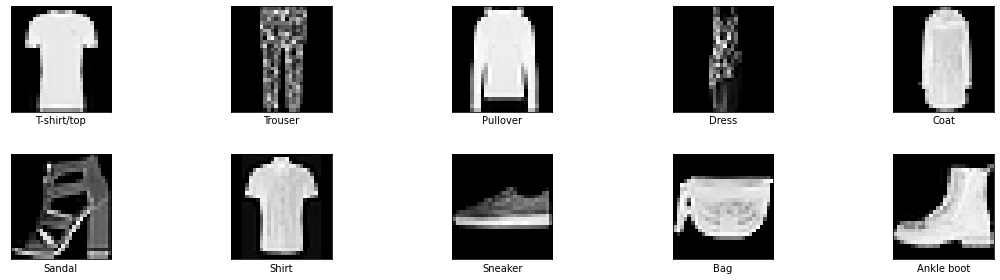

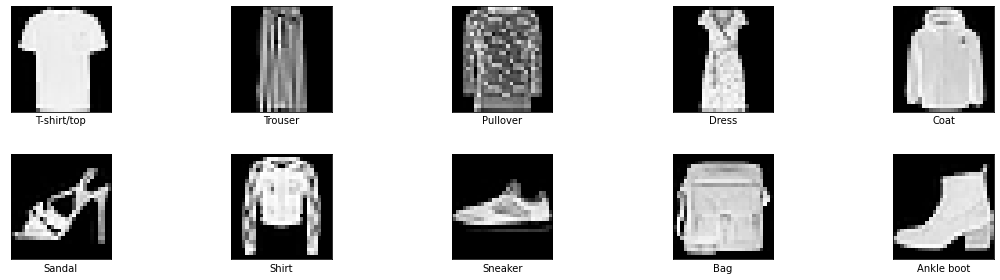

In [ ]:
print_Images(train_imgs,train_labels,MNIST_dict,random = True)
print_Images(test_imgs,test_labels,MNIST_dict,random = True)

In [ ]:
transform_train = transforms.Compose([
transforms.Pad(padding = 2, fill = 0, padding_mode='constant'),
transforms.RandomRotation(0.35), #Randomly rotate digits
transforms.ToTensor(), #convert image to PyTorch tensor
transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

transform_test = transforms.Compose([
transforms.Pad(padding = 2, fill = 0, padding_mode='constant'),                                     
transforms.ToTensor(), #convert image to PyTorch tensor
transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, X, Y, transforms):
        self.transforms = transforms
        self.X_data = X
        self.Y_data = np.array(Y,dtype = np.long)

    def __len__(self):
        # return total dataset size
        return self.X_data.shape[0]

    def __getitem__(self, index):
        img = self.X_data[index].squeeze()
        img = Image.fromarray(img, mode = 'L')
        label = self.Y_data[index]
        img_transformed = self.transforms(img)
        return img_transformed, label

BATCH_SIZE = 64
train_dataset = MNIST_Dataset(train_imgs,train_labels,transforms = transform_train)
test_dataset = MNIST_Dataset(test_imgs,test_labels,transforms = transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle= True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100,shuffle= False, num_workers=4)
N_train = train_dataset.__len__()
N_test = test_dataset.__len__()

In [ ]:
num_classes = 10
num_input_channels = 1
if model_type  == 'DenseNet':
  !cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/DenseNet/DenseNet.py DenseNet.py
  from DenseNet import DenseNet
  growth_rate = 12
  layers = [8,8,8]
  net = DenseNet(growth_rate = growth_rate,layers = layers,num_classes = num_classes,channels = num_input_channels)

elif model_type  == 'DenseNet':
  !cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/SimpleNet/SimpleNet.py SimpleNet.py
  from SimpleNet import SimpleNet
  num_classes = 10
  num_input_channels = 1
  net = SimpleNet(num_classes = num_classes,num_input_channels = num_input_channels)

In [ ]:
print(net)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (denseblock1): DenseBlock(
      (layers): ModuleDict(
        (denselayer1): DenseCompositionFunction(
          (bn_1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_1): Conv2d(24, 48, kernel_size=[1, 1], stride=[1, 1], bias=False)
          (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_2): Conv2d(48, 12, kernel_size=[3, 3], stride=[1, 1], padding=(1, 1), bias=False)
        )
        (denselayer2): DenseCompositionFunction(
          (bn_1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_1): Conv2d(36, 48, kernel_size=[1, 1], stride=[1, 1], bias=False)
          (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_2): Conv2d(48, 12, kernel_size=[3, 3]

In [ ]:
def standard_training(model,train_loader,learning_rate, num_epochs, N_train, save_dir):

  optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate,momentum = 0.9, weight_decay= 1e-5, nesterov=True)
  loss_fn = nn.CrossEntropyLoss()
  MILESTONES = [10,14]
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

  train_loss_list = []
  train_acc_list = []
  model.train()
  for epoch in range(num_epochs):
    train_acc = 0.0
    train_loss = 0.0
    for i, (X, labels) in enumerate(train_loader):
      image_batch = X.to(device)
      labels_batch = labels.to(device)
      optimizer.zero_grad()

      _, out_classifier = model(image_batch)

      loss = loss_fn(out_classifier, labels_batch)
      loss.backward()
      optimizer.step()
      train_loss += loss.cpu().data.item()*BATCH_SIZE
      _, prediction = torch.max(out_classifier.data, 1)
      train_acc += torch.sum(prediction == labels_batch.data).cpu().item()
    scheduler.step()
    train_loss_list.append(train_loss)
    train_acc = 100*train_acc /N_train
    train_acc_list.append(train_acc)
    print("Epoch {}, Train Accuracy: {:.2f}% , TrainLoss: {:.4f}".format(epoch, train_acc, train_loss))
    model.save_models(epoch,optimizer.state_dict(),save_dir)
  return train_loss_list, train_acc_list

In [ ]:
def test(model,testloader,N_test):
    test_acc = 0.0
    for i, (images, labels) in enumerate(testloader):
        image_batch = images.to(device)
        labels_batch = labels.to(device)
        model.eval()
        # Predict classes using images from the test set
        _, out_classifier = model(image_batch)
        _, prediction = torch.max(out_classifier.data, 1)

        test_acc += torch.sum(prediction == labels_batch.data).cpu().item()
    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / N_test
    print("Test Accuracy: {:.2f}%".format(100*test_acc))
    return test_acc

In [ ]:
save_dir = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/Models'

if model_type  == 'DenseNet':
  learning_rate = 1.0
  num_epochs = 20
elif model_type == 'SimpleNet':
  learning_rate = 0.1
  num_epochs = 15


train_loss_list, train_acc_list = standard_training(net.to(device),train_loader,learning_rate, num_epochs, N_train, save_dir)

Epoch 0, Train Accuracy: 71.96% , TrainLoss: 46595.6470
Check Point Saved
Epoch 1, Train Accuracy: 87.63% , TrainLoss: 21053.1927
Check Point Saved
Epoch 2, Train Accuracy: 89.29% , TrainLoss: 18188.4613
Check Point Saved
Epoch 3, Train Accuracy: 90.12% , TrainLoss: 16788.0149
Check Point Saved
Epoch 4, Train Accuracy: 90.59% , TrainLoss: 15774.4407
Check Point Saved
Epoch 5, Train Accuracy: 91.08% , TrainLoss: 14882.5724
Check Point Saved
Epoch 6, Train Accuracy: 91.48% , TrainLoss: 14420.5858
Check Point Saved
Epoch 7, Train Accuracy: 91.73% , TrainLoss: 13980.8332
Check Point Saved
Epoch 8, Train Accuracy: 91.81% , TrainLoss: 13629.4540
Check Point Saved
Epoch 9, Train Accuracy: 92.10% , TrainLoss: 13331.7898
Check Point Saved
Epoch 10, Train Accuracy: 94.18% , TrainLoss: 9568.8514
Check Point Saved
Epoch 11, Train Accuracy: 94.81% , TrainLoss: 8578.8460
Check Point Saved
Epoch 12, Train Accuracy: 95.09% , TrainLoss: 8101.3899
Check Point Saved
Epoch 13, Train Accuracy: 95.44% , Tra

In [ ]:
_ = test(net.to(device),test_loader,N_test)

# Pre-specified Codebook Manifest Model

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/LB_CNN_Models/Manifest_Model.py Manifest_Model.py
from Manifest_Model import Manifest_Model

In [ ]:
sub_problem1 = np.array([1,-1,1,-1,-1,-1,1,-1,1,1])
sub_problem2 = np.array([1,-1,-1,1,-1,-1,-1,-1,1,-1])
sub_problem3 = np.array([1,1,-1,1,-1,-1,1,1,-1,-1])
sub_problem4 = np.array([1,1,1,-1,-1,1,-1,-1,1,-1])

code_book = np.array([sub_problem1,sub_problem2,sub_problem3,sub_problem4]).T
code_book_df = pd.DataFrame(code_book,index = MNIST_dict.values(),columns = ['SubProblem1','SubProblem2','SubProblem3','SubProblem4'])

In [ ]:
code_book_df

,SubProblem1,SubProblem2,SubProblem3,SubProblem4
Zero,1,1,1,1
One,-1,-1,1,1
Two,1,-1,-1,1
Three,-1,1,1,-1
Four,-1,-1,-1,-1
Five,-1,-1,-1,1
Six,1,-1,1,-1
Seven,-1,-1,1,-1
Eight,1,1,-1,1
Nine,1,-1,-1,-1


In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, X, Y,code_book, transforms):
        self.transforms = transforms
        self.X_data = X
        self.Y_data = np.array(Y,dtype = np.long)
        self.Z = np.stack([code_book[y,:] for y in self.Y_data],axis =0).astype(np.float32)

    def __len__(self):
        # return total dataset size
        return self.X_data.shape[0]

    def __getitem__(self, index):
        img = self.X_data[index].squeeze()
        img = Image.fromarray(img, mode = 'L')
        label = self.Y_data[index]
        z = self.Z[index,:]
        img_transformed = self.transforms(img)
        return img_transformed, label, z

BATCH_SIZE = 64
train_dataset = MNIST_Dataset(train_imgs,train_labels,code_book, transforms = transform_train)
test_dataset = MNIST_Dataset(test_imgs,test_labels,code_book, transforms = transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle= True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100,shuffle= False, num_workers=4)
N_train = train_dataset.__len__()
N_test = test_dataset.__len__()

In [ ]:
class LogLikelihood_Loss(torch.nn.Module):
    def __init__(self):
        super(LogLikelihood_Loss,self).__init__()
    def forward(self,ll):
        self.ll = ll
        self.neg_ll = -1.0*self.ll
        self.neg_ll = self.neg_ll /BATCH_SIZE
        return self.neg_ll

In [ ]:
def manifest_training(model,cnn_model,train_loader,learning_rate, num_epochs, N_train, save_dir):
  params =[{'params':cnn_model.parameters(), 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.beta_tensor, 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.beta_0_tensor, 'lr': learning_rate, 'weight_decay': 0},
            {'params': model.alpha_tensor, 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.alpha_0_tensor, 'lr': learning_rate, 'weight_decay': 0}]

  optimizer = torch.optim.SGD(params, lr= learning_rate,momentum = 0.9, weight_decay= 1e-5, nesterov=True)
  loss_fn = LogLikelihood_Loss()
  MILESTONES = [7,9]
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

  train_loss_list = []
  train_acc_list = []
  train_acc_list2 = []
  model.train()
  cnn_model.train()
  for epoch in range(num_epochs):
    train_acc = 0.0
    train_acc2 = 0.0
    train_loss = 0.0
    for i, (X, labels, bern_labels) in enumerate(train_loader):
      image_batch = X.to(device)
      labels_batch = labels.to(device)
      Z_batch = bern_labels.to(device)
      optimizer.zero_grad()

      out, out_classifier = cnn_model(image_batch)

      ll = model(out,Z_batch,labels_batch)

      loss = loss_fn(ll)
      loss.backward()
      optimizer.step()
      train_loss += loss.cpu().data.item()*BATCH_SIZE
      Y_pred_Z,Y_pred_EZ = model.predict_Y(out)

      train_acc += torch.sum(Y_pred_Z == labels_batch.data).cpu().item()
      train_acc2 += torch.sum(Y_pred_EZ == labels_batch.data).cpu().item()
    scheduler.step()
    train_loss_list.append(train_loss)
    train_acc = 100*train_acc /N_train
    train_acc2 = 100*train_acc2 /N_train
    train_acc_list.append(train_acc)
    train_acc_list2.append(train_acc2)
    print("Epoch {}, Train Accuracy: {:.2f}%, Train Accuracy E[Z|X]: {:.2f}% , TrainLoss: {:.4f}".format(epoch, train_acc, train_acc2, train_loss))
    model.save_models(epoch,optimizer.state_dict(),save_dir)
  return train_loss_list, train_acc_list, train_acc_list2

In [ ]:
def manifest_test(model,cnn_model,testloader,N_test):
    test_acc = 0.0
    test_acc2 = 0.0
    cnn_model.eval()
    model.eval()
        
    for i, (X, labels, bern_labels) in enumerate(test_loader):
        image_batch = X.type(torch.FloatTensor).to(device)
        Z_batch = bern_labels.type(torch.FloatTensor).to(device)
        labels_batch = labels.type(torch.LongTensor).to(device)
        
        
        out, out_classifier = cnn_model(image_batch)
        
        Y_pred,Y_predEZ = model.predict_Y(out)

        test_acc += torch.sum(Y_pred == labels_batch.data).cpu().item()
        test_acc2 += torch.sum(Y_predEZ == labels_batch.data).cpu().item()
    
    test_acc = test_acc / N_test
    test_acc2 = test_acc2 / N_test
    print("Test Accuracy: {:.2f}%".format(100*test_acc))
    print("Test Accuracy using E[Z|X]: {:.2f}%".format(100*test_acc2))
    return test_acc

In [ ]:
if model_type  == 'DenseNet':
  num_features = 174
elif model_type == 'SimpleNet':
  num_features = 256

num_classes = 10
code_size = 4
net_manifest = Manifest_Model(num_features,num_classes,code_size)

In [ ]:
save_dir = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/Models'
learning_rate = 0.1
num_epochs = 10
train_loss_list, train_acc_list, train_acc_list2 = manifest_training(net_manifest.to(device),net.to(device),train_loader,learning_rate, num_epochs, N_train, save_dir)

Epoch 0, Train Accuracy: 98.56%, Train Accuracy E[Z|X]: 98.60% , TrainLoss: 6781.7542
Check Point Saved
Epoch 1, Train Accuracy: 99.34%, Train Accuracy E[Z|X]: 99.37% , TrainLoss: 2446.3575
Check Point Saved
Epoch 2, Train Accuracy: 99.47%, Train Accuracy E[Z|X]: 99.50% , TrainLoss: 1958.1570
Check Point Saved
Epoch 3, Train Accuracy: 99.47%, Train Accuracy E[Z|X]: 99.49% , TrainLoss: 1856.1017
Check Point Saved
Epoch 4, Train Accuracy: 99.56%, Train Accuracy E[Z|X]: 99.59% , TrainLoss: 1509.7977
Check Point Saved
Epoch 5, Train Accuracy: 99.64%, Train Accuracy E[Z|X]: 99.65% , TrainLoss: 1246.4372
Check Point Saved
Epoch 6, Train Accuracy: 99.69%, Train Accuracy E[Z|X]: 99.70% , TrainLoss: 1077.6213
Check Point Saved
Epoch 7, Train Accuracy: 99.85%, Train Accuracy E[Z|X]: 99.85% , TrainLoss: 536.5147
Check Point Saved
Epoch 8, Train Accuracy: 99.92%, Train Accuracy E[Z|X]: 99.92% , TrainLoss: 364.2353
Check Point Saved
Epoch 9, Train Accuracy: 99.91%, Train Accuracy E[Z|X]: 99.92% , T

In [ ]:
_ = manifest_test(net_manifest.to(device),net.to(device),test_loader,N_test)

Test Accuracy: 99.52%
Test Accuracy using E[Z|X]: 99.54%


# Treat Code as Latent and use EM Algorithm

In [ ]:
class MNIST_Dataset(Dataset):
    def __init__(self, X, Y, transforms):
        self.transforms = transforms
        self.X_data = X
        self.Y_data = np.array(Y,dtype = np.long)

    def __len__(self):
        # return total dataset size
        return self.X_data.shape[0]

    def __getitem__(self, index):
        img = self.X_data[index].squeeze()
        img = Image.fromarray(img, mode = 'L')
        label = self.Y_data[index]
        img_transformed = self.transforms(img)
        return img_transformed, label

BATCH_SIZE = 64
train_dataset = MNIST_Dataset(train_imgs,train_labels,transforms = transform_train)
test_dataset = MNIST_Dataset(test_imgs,test_labels,transforms = transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle= True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100,shuffle= False, num_workers=4)
N_train = train_dataset.__len__()
N_test = test_dataset.__len__()

In [ ]:
class LogLikelihood_Loss(torch.nn.Module):
    def __init__(self):
        super(LogLikelihood_Loss,self).__init__()
    def forward(self,ll):
        self.ll = ll
        self.neg_ll = -1.0*self.ll
        self.neg_ll = self.neg_ll /BATCH_SIZE
        return self.neg_ll

In [ ]:
def latent_training(model,cnn_model,train_loader,learning_rate, num_epochs, N_train, save_dir):
  params =[{'params':cnn_model.parameters(), 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.beta_tensor, 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.beta_0_tensor, 'lr': learning_rate, 'weight_decay': 0},
            {'params': model.alpha_tensor, 'lr': learning_rate, 'weight_decay': 1e-5},
            {'params': model.alpha_0_tensor, 'lr': learning_rate, 'weight_decay': 0}]

  optimizer = torch.optim.SGD(params, lr= learning_rate,momentum = 0.9, weight_decay= 1e-5, nesterov=True)
  loss_fn = LogLikelihood_Loss()
  MILESTONES = [7,9]
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

  train_loss_list = []
  train_acc_list = []
  train_acc_list2 = []
  model.train()
  cnn_model.train()
  for epoch in range(num_epochs):
    train_acc = 0.0
    train_acc2 = 0.0
    train_loss = 0.0
    for i, (X, labels) in enumerate(train_loader):
      image_batch = X.to(device).type(torch.FloatTensor).to(device)
      labels_batch = labels.to(device)
      optimizer.zero_grad()

      out, out_classifier = cnn_model(image_batch)

      ll = model(out,labels_batch)

      loss = loss_fn(ll)
      loss.backward()
      optimizer.step()
      train_loss += loss.cpu().data.item()*BATCH_SIZE
      Y_pred_Z,Y_pred_EZ = model.predict_Y(out)

      train_acc += torch.sum(Y_pred_Z == labels_batch.data).cpu().item()
      train_acc2 += torch.sum(Y_pred_EZ == labels_batch.data).cpu().item()
    scheduler.step()
    train_loss_list.append(train_loss)
    train_acc = 100*train_acc /N_train
    train_acc2 = 100*train_acc2 /N_train
    train_acc_list.append(train_acc)
    train_acc_list2.append(train_acc2)
    print("Epoch {}, Train Accuracy: {:.2f}%, Train Accuracy E[Z|X]: {:.2f}% , TrainLoss: {:.4f}".format(epoch, train_acc, train_acc2, train_loss))
  model.save_models(epoch,optimizer.state_dict(),save_dir)
  return train_loss_list, train_acc_list, train_acc_list2

In [ ]:
def latent_test(model,cnn_model,testloader,N_test):
    test_acc = 0.0
    test_acc2 = 0.0
    cnn_model.eval()
    model.eval()
        
    for i, (X, labels) in enumerate(test_loader):
        image_batch = X.type(torch.FloatTensor).to(device)
        labels_batch = labels.type(torch.LongTensor).to(device)
        out, out_classifier = cnn_model(image_batch)
        Y_pred,Y_predEZ = model.predict_Y(out)

        test_acc += torch.sum(Y_pred == labels_batch.data).cpu().item()
        test_acc2 += torch.sum(Y_predEZ == labels_batch.data).cpu().item()
    
    test_acc = test_acc / N_test
    test_acc2 = test_acc2 / N_test
    print("Test Accuracy: {:.2f}%".format(100*test_acc))
    print("Test Accuracy using E[Z|X]: {:.2f}%".format(100*test_acc2))
    return test_acc

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/LB_CNN_Models/LB_CNN.py LB_CNN.py
from LB_CNN import LB_CNN

In [ ]:
if model_type  == 'DenseNet':
  num_features = 174
elif model_type == 'SimpleNet':
  num_features = 256
num_classes = 10
latent_size = 4
latent_net1 = LB_CNN(num_features,num_classes,latent_size)

In [ ]:
save_dir = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/Models'
learning_rate = 0.1
num_epochs = 10
train_loss_list, train_acc_list, train_acc_list2 = latent_training(latent_net1.to(device),net.to(device),train_loader,learning_rate, num_epochs, N_train, save_dir)

Epoch 0, Train Accuracy: 96.49%, Train Accuracy E[Z|X]: 96.76% , TrainLoss: 7219.4380
Epoch 1, Train Accuracy: 99.83%, Train Accuracy E[Z|X]: 99.86% , TrainLoss: 938.4858
Epoch 2, Train Accuracy: 99.78%, Train Accuracy E[Z|X]: 99.79% , TrainLoss: 972.4052
Epoch 3, Train Accuracy: 99.75%, Train Accuracy E[Z|X]: 99.77% , TrainLoss: 1044.4536
Epoch 4, Train Accuracy: 99.91%, Train Accuracy E[Z|X]: 99.92% , TrainLoss: 494.4543
Epoch 5, Train Accuracy: 99.76%, Train Accuracy E[Z|X]: 99.78% , TrainLoss: 987.0050
Epoch 6, Train Accuracy: 99.80%, Train Accuracy E[Z|X]: 99.83% , TrainLoss: 860.6240
Epoch 7, Train Accuracy: 99.91%, Train Accuracy E[Z|X]: 99.91% , TrainLoss: 502.1976
Epoch 8, Train Accuracy: 99.94%, Train Accuracy E[Z|X]: 99.95% , TrainLoss: 350.2864
Epoch 9, Train Accuracy: 99.95%, Train Accuracy E[Z|X]: 99.96% , TrainLoss: 321.8033
Check Point Saved


In [ ]:
_ = latent_test(latent_net1.to(device),net.to(device),test_loader,N_test)

Test Accuracy: 99.60%
Test Accuracy using E[Z|X]: 99.62%
